In [1]:
from pathlib import Path
from pprint import pformat
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import HTML

from pixloc.settings import DATA_PATH, LOC_PATH
from pixloc.localization import RetrievalLocalizer, SimpleTracker
from pixloc.pixlib.geometry import Camera, Pose
from pixloc.visualization.viz_2d import (
    plot_images, plot_keypoints, add_text, features_to_RGB)
from pixloc.visualization.animation import (
    subsample_steps, VideoWriter, create_viz_dump, display_video)
from pixloc.localization.localizer import lysLocalizer

In [2]:
# 场景选择
dataset = 'stairs'

if dataset == 'Aachen':
    from pixloc.run_Aachen import default_paths, default_confs
elif dataset == 'CMU':
    from pixloc.run_CMU import default_paths, default_confs
    default_paths = default_paths.interpolate(slice=21)
else:
    from pixloc.run_scripts import default_paths, default_confs
    default_paths = default_paths.interpolate(scene=dataset)
    
print(f'default paths:\n{pformat(default_paths.asdict())}')
paths = default_paths.add_prefixes(DATA_PATH, LOC_PATH)

conf = default_confs['from_retrieval']
conf['refinement']['do_pose_approximation'] = False
print(f'conf:\n{pformat(conf)}')

# localizer = lysLocalizer(paths, conf)
localizer = RetrievalLocalizer(paths, conf)

[06/07/2023 16:55:48 pixloc.localization.model3d INFO] Reading COLMAP model /home/lys/Workplace/datasets/stairs_outputs/colmap_db/sfm_superpoint+superglue.


default paths:
{'dataset': None,
 'dumps': None,
 'global_descriptors': PosixPath('stairs_outputs/colmap_db/global-feats-netvlad.h5'),
 'ground_truth': PosixPath('stairs_outputs/colmap_full/sfm_superpoint+superglue'),
 'hloc_logs': None,
 'query_images': PosixPath('stairs'),
 'query_list': PosixPath('stairs_outputs/query_list_with_intrinsics.txt'),
 'reference_images': PosixPath('stairs'),
 'reference_sfm': PosixPath('stairs_outputs/colmap_db/sfm_superpoint+superglue'),
 'results': PosixPath('stairs_outputs/results/pixloc_outputs.txt'),
 'retrieval_pairs': PosixPath('stairs_outputs/netvlad/pairs-query-netvlad.txt')}
conf:
{'experiment': 'pixloc_megadepth',
 'features': {},
 'optimizer': {'num_iters': 100, 'pad': 2},
 'refinement': {'average_observations': False,
                'do_pose_approximation': False,
                'filter_covisibility': False,
                'multiscale': [4, 2],
                'normalize_descriptors': True,
                'num_dbs': 1,
                'p

[06/07/2023 16:55:48 pixloc.pixlib.utils.experiments INFO] Loading checkpoint checkpoint_best.tar


In [3]:
# 载入图片
name_q = np.random.choice(list(localizer.queries))  # pick a random query

#905 新车库 旧车库
# name_q='query/IMG_0119.JPG'
# name_q='night/IMG_5345.JPG'
# name_q='query_dif_time/IMG_6652.JPG'

name_q='seq-04/frame-000468.color.png'



tracker = SimpleTracker(localizer.refiner)  # will hook & store the predictions
cam_q = Camera.from_colmap(localizer.queries[name_q])
ret = localizer.run_query(name_q, cam_q)

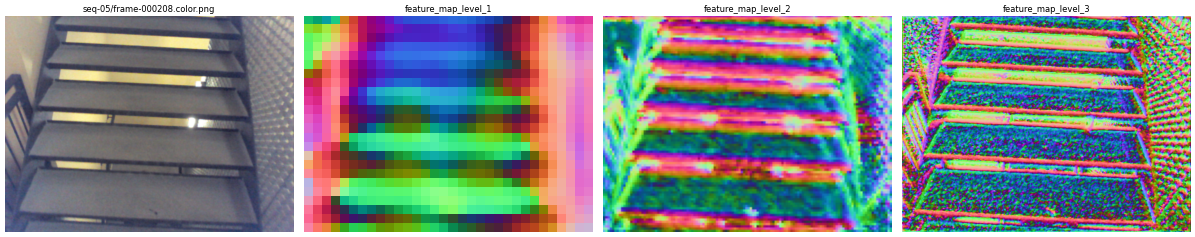

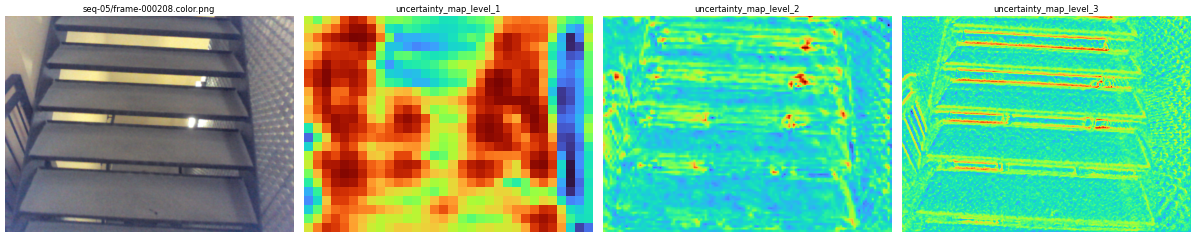

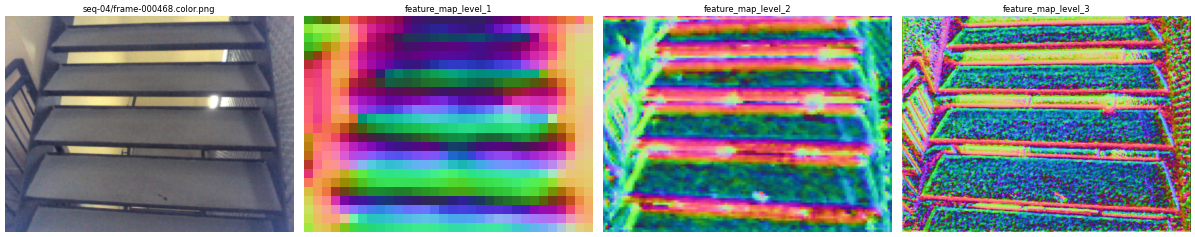

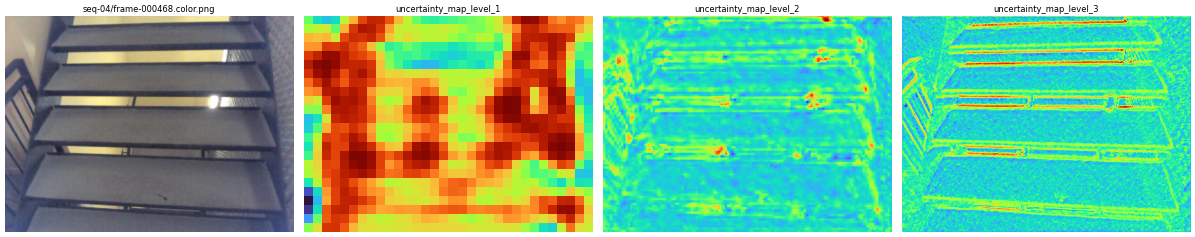

In [4]:
# 展示CNN特征提取图和预测图 
ref_ids = ret['dbids'][:3]  # show 3 references at most
names_r = [localizer.model3d.dbs[i].name for i in ref_ids]
# for name in names_r + [name_q]:
#     image, features, weights = tracker.dense[name][1]
#     features = features_to_RGB(features[1].numpy())[0]
#     plot_images([image, features, weights[1]], cmaps='turbo',
#                 titles=[name, 'features', 'confidence'], dpi=50)
for name in names_r + [name_q]:
    image, features, weights = tracker.dense[name][2]
    features2 = features_to_RGB(features[0].numpy())[0]
    features1 = features_to_RGB(features[1].numpy())[0]
    features0 = features_to_RGB(features[2].numpy())[0]

    plot_images([image, features0,features1,features2], cmaps='turbo',
                titles=[name, 'feature_map_level_1','feature_map_level_2','feature_map_level_3' ], dpi=50)
    plot_images([image, weights[2],weights[1],weights[0]], cmaps='turbo',
                titles=[name, 'uncertainty_map_level_1','uncertainty_map_level_2','uncertainty_map_level_3' ], dpi=50)

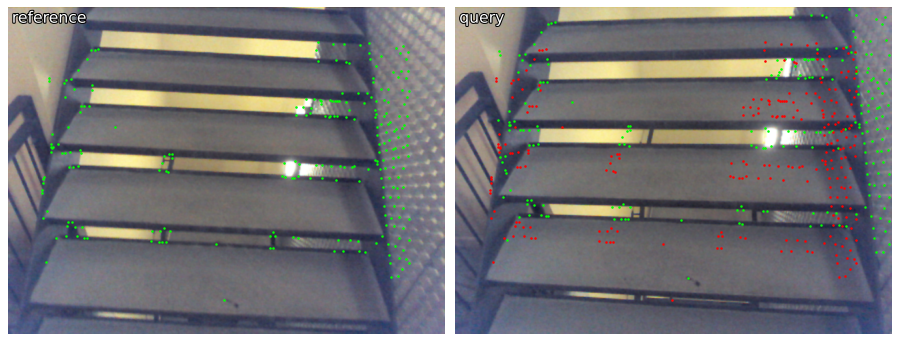

In [5]:
# 展示初始和最终位姿
# Pick the first reference image for visualization
ref_id = ref_ids[0]
name_r = names_r[0]
ref = localizer.model3d.dbs[ref_id]
cam_r = Camera.from_colmap(localizer.model3d.cameras[ref.camera_id])
T_w2r = Pose.from_colmap(ref)

image_r = tracker.dense[name_r][2][0]
image_q = tracker.dense[name_q][2][0]
p3d = tracker.p3d
T_w2q_init = tracker.T[0]
T_w2q_final = tracker.T[-1]

# Project the 3D points
p2d_r, mask_r = cam_r.world2image(T_w2r * p3d)
p2d_f, mask_f = cam_q.world2image(T_w2q_final * p3d)
p2d_i, mask_i = cam_q.world2image(T_w2q_init * p3d)

plot_images([image_r, image_q], dpi=75)
plot_keypoints([p2d_r[mask_r], p2d_f[mask_f]], 'lime')
plot_keypoints([None, p2d_i[mask_i]], 'red')
# plot_keypoints([p2d_r[mask_r], p2d_i[mask_i]], 'lime')
# plot_keypoints([None, p2d_f[mask_f]], 'red')
add_text(0, 'reference')
add_text(1, 'query')


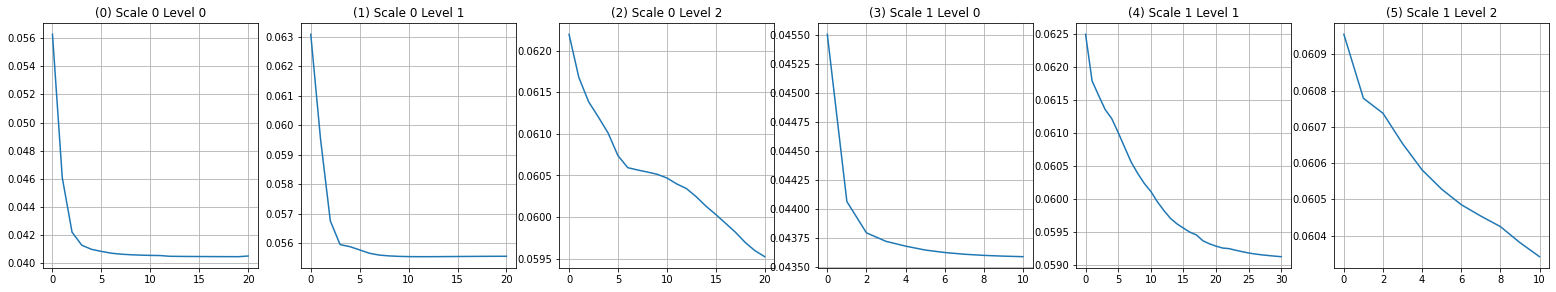

In [6]:
#  迭代过程损失函数图
costs = tracker.costs
fig, axes = plt.subplots(1, len(costs), figsize=(len(costs)*4.5, 4.5))
for i, (ax, cost) in enumerate(zip(axes, costs)):
    ax.plot(cost) if len(cost)>1 else ax.scatter(0., cost)
    ax.set_title(f'({i}) Scale {i//3} Level {i%3}')
    ax.grid()

In [7]:
# 迭代过程保存
T_w2q_all = torch.stack(tracker.T)
p2d_q_all, mask_q_all = cam_q.world2image(T_w2q_all * p3d)
keep = subsample_steps(T_w2q_all, p2d_q_all, mask_q_all, cam_q.size.numpy())
print(f'Keep {len(keep)}/{len(p2d_q_all)} optimization steps for visualization.')

video = 'pixloc.mp4'
writer = VideoWriter('./tmp')
for i in tqdm(keep):
    plot_images([image_r, image_q], dpi=100, autoscale=False)
    plot_keypoints([p2d_r[mask_r], p2d_q_all[i][mask_q_all[i]]], 'lime',ps=20)
    plot_keypoints([None, p2d_q_all[-1][mask_q_all[-1]]], 'red',ps=20)
#     plot_keypoints([p2d_r[mask_r], p2d_q_all[-1][mask_q_all[-1]]], 'lime',ps=20)
#     plot_keypoints([None, p2d_q_all[i][mask_q_all[i]]], 'red',ps=20)
#     add_text(0, 'reference')
#     add_text(1, 'query')
    writer.add_frame()


Keep 92/122 optimization steps for visualization.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [00:18<00:00,  4.90it/s]


In [8]:
# 将最后展示效果保存至server中
# the path relative to the viewer folder
viewer = Path('../viewer')
assets = viewer / 'dumps/sample'

# set the Y axis up for threejs
# tfm = np.eye(3)
tfm = np.diag([-1, -1, 1])
if dataset == 'CMU':
    tfm = np.array([[1, 0, 0], [0, 0, 1], [0, -1, 0]])
elif dataset == '7Scenes':
    tfm = np.diag([1, -1, -1])
elif dataset=='lys_241_new':
    tfm = np.diag([1, -1, -1])

# Write a json dump to viewer/assets/sample.json
create_viz_dump(
    assets, paths, cam_q, name_q, T_w2q_all[keep],
    mask_q_all[keep], p2d_q_all[keep],
    ref_ids, localizer.model3d, tracker.p3d_ids, tfm=tfm)

with open(viewer / 'jupyter.html', 'r') as f:
    html = f.read()
html = html.replace('{__path__}', str(viewer))
html = html.replace('{__assets__}', str(assets.parent))
html = html.replace('{__height__}', '600px')
HTML(html)

In [9]:
# import matplotlib.pyplot as plt
# import numpy as np
# from mpl_toolkits.mplot3d import Axes3D

# # img_name: 'xyz' : [x,y,z]
# #           'our_err' :Δt
# #           'pix_err' :Δt

# ana_list = {}

# # 读取gt_xyz
# with open('/home/lys/Workplace/datasets/test/pumpkin/camera_track_gt.txt', 'r') as f:
#     lines = f.readlines()
# for line in lines:
#     id, x_, y_, z_ = line.strip().split()
#     ana_list[id] = {"xyz": [float(x_), float(y_), float(z_)]}

# # 读取our_err
# with open('/home/lys/Workplace/datasets/test/pumpkin/our_error.txt', 'r') as f:
#     lines = f.readlines()
# for line in lines:
#     id, _err = line.strip().split()
#     if id in ana_list:
#         ana_list[id].update({"our_err": float(_err)*100})

# # 读取pix_err
# with open('/home/lys/Workplace/datasets/test/pumpkin/pixloc_error.txt', 'r') as f:
#     lines = f.readlines()
# for line in lines:
#     id, _err = line.strip().split()
#     if id in ana_list:
#         ana_list[id].update({"pix_err": float(_err)*100})

# # 读取mapnet_err
# with open("/home/lys/Workplace/datasets/test/pumpkin/pumpkin_mapnet_loss.txt", 'r') as f:
#     lines = f.readlines()

# for idx, key in enumerate(sorted(ana_list.keys())):
#     ana_list[key].update({"mapnet_err": float(lines[idx])*100})
#     # print(idx,key)

# # 读取posenet_err
# with open("/home/lys/Workplace/datasets/test/pumpkin/pumpkin_posnet_loss.txt", 'r') as f:
#     lines = f.readlines()

# for idx, key in enumerate(sorted(ana_list.keys())):
#     ana_list[key].update({"posenet_err": float(lines[idx])*100})

# # 控制画布大小和相关参数 
# plt.rcParams['figure.figsize'] = [40, 30]
# plt.rcParams['figure.facecolor'] = 'white'

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.set_facecolor('white')

# # 设置颜色
# r, g, b = 1, 0.05, 0.05
# ourcolor = (r, g, b)

# r, g, b = 0.2, 0.345, 0.6
# pixloccolor = (r, g, b)

# r, g, b = 0.45, 0.68, 0.29
# mapcolor = (r, g, b)
# # 
# r, g, b = 1, 0.768,0.082
# posecolor = (r, g, b)

# for name in ana_list:
#     p = ana_list[name]['xyz']
#     our_err = ana_list[name]['our_err']
#     pix_err = ana_list[name]['pix_err']
#     pose_err = ana_list[name]['posenet_err']
#     mapnet_err = ana_list[name]['mapnet_err']

#     if our_err < 40:
#         ax.quiver(p[0], p[1], p[2], 0, 0, 1, color=ourcolor,
#                 length=our_err/400, normalize=True)
#     if pix_err < 40:
#         ax.quiver(p[0], p[1], p[2], 0, 0, -1, color=pixloccolor,
#                 length=pix_err/400, normalize=True)
#     if mapnet_err < 40:
#         ax.quiver(p[0], p[1], p[2], 0, -1, 0, color=mapcolor,
#                 length=np.log1p(mapnet_err/800), normalize=True)
#     if pose_err < 40:
#         ax.quiver(p[0], p[1], p[2], 0, 1, 0, color=posecolor,
#                 length=np.log1p(pose_err/800), normalize=True)
#     ax.scatter(p[0], p[1], p[2], c='black', marker='o', s=5)
# # ax.scatter(x2, y2, z2, c='g', marker='^', s=5)

# # ax.set_xlim([-1, 1])
# # ax.set_ylim([-0.5, 0.4])
# # ax.set_zlim([-0.3, 0.4])

# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')
# plt.savefig('/home/lys/Workplace/datasets/test/office.png', bbox_inches='tight')
# plt.show()

In [10]:
# plt.savefig('/home/lys/Workplace/datasets/test/office.png', bbox_inches='tight')